In [1]:
import glob
import pandas as pd
import os

from imblearn.over_sampling import RandomOverSampler 

from sklearn.model_selection import train_test_split

from transformers import DistilBertTokenizerFast

import torch

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# %%time
# path = '../datasets/merged/'
# all_files = glob.glob(os.path.join(path, "*.csv"))

# df_from_each_file = (pd.read_csv(f) for f in all_files)
# df = pd.concat(df_from_each_file, ignore_index=True)

In [3]:
category_list = [
    'appliances',
    'arts_crafts_and_sewing',
    'automotive',
    'baby',
    'beauty',
    'cell_phones_and_accessories',
    'clothing_shoes_and_jewelry',
    'electronics',
    'grocery_and_gourmet_food',
    'health_and_personal_care',
    'home_and_kitchen',
    'industrial_and_scientific',
    'musical_instruments',
    'office_products',
    'patio_lawn_and_garden',
    'pet_supplies',
    'software',
    'sports_and_outdoors',
    'tools_and_home_improvement',
    'toys_and_games',
    'video_games',
]

In [4]:
# df['label'] = df['category'].map(lambda x: category_list.index(x))

In [5]:
# df.to_csv('../datasets/cleaned/merged_by_asin.csv')
df = pd.read_csv('../datasets/cleaned/merged_by_asin.csv')

In [6]:
df

,Unnamed: 0,text,category,asin,label
0,0,"I have Windows 8, Will this work on my compute...",software,439381673,16
1,1,What do you use to write on the leaves that ca...,office_products,439537886,13
2,2,Are both sides white? Are both sides magnetic?...,toys_and_games,439893577,19
3,3,how do you hang it? does it include adhesive? ...,office_products,545114780,13
4,4,Is this a pocket chart or just some cards for ...,office_products,545114985,13
...,...,...,...,...,...
182017,182017,What is Argan Oil made for? To soften skin. He...,beauty,B00L5JHZJO,4
182018,182018,Is there a time period requirement on the mont...,electronics,B00L8A94AI,7
182019,182019,Can you tell me what approximate area or sq fo...,health_and_personal_care,B00L9NR672,9
182020,182020,Is the case battery back cover door with water...,cell_phones_and_accessories,B00LMJJOD2,5


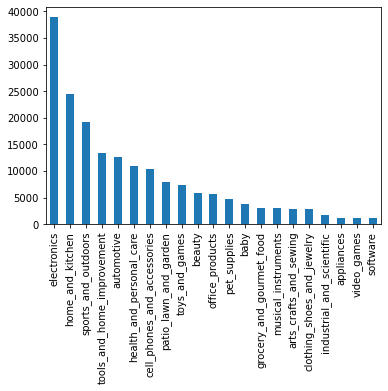

In [7]:
df['category'].value_counts(normalize=False).plot(kind='bar');

In [8]:
# ros = RandomOverSampler(random_state=42)
X = df[['text', 'asin']]
y = df['label']
# X_res, y_res = ros.fit_resample(X, y)

In [9]:
# y_res.value_counts(normalize=False).plot(kind='bar');

In [10]:
# y_res.shape

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
#     X_res, y_res,
    X, y,
    test_size=.1, 
    random_state=42, 
#     stratify=y_res)
    stratify=y)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=.2, 
    random_state=42, 
    stratify=y_train_val)

In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [14]:
%%time
train_encodings = tokenizer(list(X_train['text']), truncation=True, padding=True, max_length=128)

Wall time: 3min 11s


In [15]:
%%time
val_encodings = tokenizer(list(X_val['text']), truncation=True, padding=True, max_length=128)

Wall time: 3min 45s


In [16]:
%%time
test_encodings = tokenizer(list(X_test['text']), truncation=True, padding=True, max_length=128)

Wall time: 3min 41s


In [17]:
class AmazonDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
%%time
train_dataset = AmazonDataset(train_encodings, list(y_train))
val_dataset = AmazonDataset(val_encodings, list(y_val))
test_dataset = AmazonDataset(test_encodings, list(y_test))

Wall time: 15 ms


In [23]:
len(train_dataset)

131055

In [24]:
len(val_dataset)

32764

In [22]:
train_dataset.__getitem__(2)

{'input_ids': tensor([  101,  2515,  2009,  4906,  2005, 18798, 16059,  2801, 15455,  1061,
         29537,  1029,  2748,  2009,  2323,  4906,  1012,  2129,  2079,  2017,
         16500,  2023,  1029,  2515,  1996,  2173,  2073,  1996,  4966, 11851,
          2052,  2175,  2428,  8687,  2135,  2735,  2046,  1037,  2047,  2173,
          2005,  1037,  2938,  2050,  1029,  2748,  2009,  2515,  1012,  1045,
          2031,  1037, 19102, 28122, 23408,  2080,  4013, 11899, 18259,  7020,
          2094,  1012,  2026,  2801, 15455,  1052, 29537,  2085,  6879,  2013,
          2125,  2000,  3645,  1022,  1999,  1020,  3823,  1012,  2196,  2224,
          1996,  3729,  9297,  4902,  1012,  3435,  3352,  1996, 28491,  9785,
          1012,  1012,  2515,  2023,  4906,  1996, 18798, 16059,  2228, 15455,
          1052, 27814,  2692,  1029,  2053,  1012,  2003,  2023,  2938,  2050,
          3523,  1029,  4067,  2017,  1012,  2053,  2009,  1005,  1055,  2069,
          2938,  2050,  2462,  1012,  2

In [20]:
%%time
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=2,  # batch size per device during training
    per_device_eval_batch_size=4,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [25]:
%%time
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

IndexError: Target 7 is out of bounds.